<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">IFT 6135 - Homework 3</div>

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import time
import samplers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

# Problem 1 :

## Question 1.1:

In order to estimate the Jensen Shannon Divergence, we will train a parametrized discriminator $D_\theta$ trained to maximize the objective function (1). After training, provided that our discriminator is of sufficient capacity, the objective function will approximate the JSD between $p$ and $q$.

* **First**, we implement the objective function
* **Second**, we create a discriminator $D_\theta$ in the form of an MLP with 3 hidden layers. As we deduce from (1) that $\forall x, D_\theta(x) \in ]0,1[$, the output non-linearity is a sigmoid
* **Third**, we implement a function that, provided 2 samplers of the distributions $p,q$, compute the JSD by training the discriminator (for 30 000 steps) and returning the last objective value computed.

The objective function that our neural network should optimize in the case we are using the Jensen Shannon Divergence is: 

<h4 align="center"> $obj =  \log 2 + \dfrac{1}{2} \mathbb{E}_{x \sim p} [ \log D_\theta (x) ] + \dfrac{1}{2} \mathbb{E}_{y \sim q} [ \log(1 - D_\theta(y))] \quad  \quad (1)$ </h4>

In the case we are using batches of size $m$, this expression is approximated by:

<h4 align="center"> $obj \simeq  \log 2 + \dfrac{1}{2 m} \sum_{i=1}^m  \log D_\theta (x_i)  + \dfrac{1}{2m} \sum_{i=1}^m \log(1 - D_\theta(y_i))$ </h4>

In [141]:
class objective_function_JSD(nn.Module):
    
    def __init__(self):
        super(objective_function_JSD, self).__init__()
    
    def forward(self, D_p, D_q):
        
        objective = torch.log(torch.tensor([2.])).cuda() + 0.5*torch.mean(torch.log(D_p)).cuda() + 0.5*torch.mean(torch.log(1 - D_q)).cuda()
        
        return(objective)

In [142]:
class Discriminator(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Discriminator, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        D = F.relu(self.hidden1(x))
        D = F.relu(self.hidden2(D))
        D = F.relu(self.hidden3(D))
        D = torch.sigmoid(self.out(D))
        
        return(D)

In [157]:
def approx_JSD(iter_sampler_p, iter_sampler_q, print_evolution = True):
    
    samples_p = torch.FloatTensor(next(iter_sampler_p)).cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_q)).cuda()
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Discriminator(input_dim, n_hidden).cuda()
    obj_func = objective_function_JSD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        d_p = MLP(samples_p)
        d_q = MLP(samples_q)
        loss = -obj_func(d_p, d_q)
        loss.backward()
        optimizer.step()
        
        samples_p = torch.FloatTensor(next(iter_sampler_p)).cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_q)).cuda()
        
        obj = float(obj_func(d_p, d_q))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(obj)

## Question 1.2

We procede in the same way than **Q.1.1**, except that now the objective to maximize is:

<h4 align="center"> $\mathbf{E}_{x\sim p}[T_\theta(x)]-\mathbf{E}_{y\sim q}[T_\theta(y)] - \lambda \mathbf{E}_{z\sim r} [(||\nabla_z T_\theta(z)||_2 - 1)^2]$ </h4>
 
 with $r$ the distribution over $z=ax+(1-a)y$, where $x\sim p$, $y\sim q$ and $a\sim U[0,1]$. We also have $\lambda \geq 10$.

* We fix $\lambda = 10$
* We change the output activation function compared to before *(here we finish with a linear one)*

In [123]:
class objective_function_WD(nn.Module):
    
    def __init__(self):
        super(objective_function_WD, self).__init__()
    
    def forward(self, T_p, T_q, grad_T_r, lmbd):
        
        objective = torch.mean(T_p - T_q - lmbd*(torch.norm(grad_T_r, dim=1) - 1)**2).cuda()
        
        return(objective)

In [124]:
class Critic(nn.Module):
    
    def __init__(self, input_dim, n_hidden):
        super(Critic, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        
        T = F.relu(self.hidden1(x))
        T = F.relu(self.hidden2(T))
        T = F.relu(self.hidden3(T))
        T = self.out(T)
        
        return(T)

In [182]:
def approx_WD(iter_sampler_p, iter_sampler_q, print_evolution=True):
    
    samples_a = torch.FloatTensor(np.random.uniform(0, 1, (512, 1))).cuda()
    samples_p = torch.FloatTensor(next(iter_sampler_p)).requires_grad_().cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_q)).requires_grad_().cuda()
    samples_r = samples_a*samples_p + (1-samples_a)*samples_q
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Critic(input_dim, n_hidden).cuda()
    obj_func = objective_function_WD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        t_p = MLP(samples_p)
        t_q = MLP(samples_q)
        t_r = MLP(samples_r)
        grad_t_r = torch.autograd.grad(t_r, samples_r, grad_outputs=torch.ones(512, input_dim).cuda(), create_graph=True)[0].cuda()
        loss = -obj_func(t_p, t_q, grad_t_r, 10)
        loss.backward()
        optimizer.step()
        
        samples_a = torch.FloatTensor(np.random.uniform(0, 1, (512, 1))).cuda()
        samples_p = torch.FloatTensor(next(iter_sampler_p)).requires_grad_().cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_q)).requires_grad_().cuda()
        samples_r = samples_a*samples_p + (1-samples_a)*samples_q

        obj = float(obj_func(t_p, t_q, grad_t_r, 11))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(obj)

## Question 1.3

We use the two functions $\texttt{approx_JSD}$ and $\texttt{approx_WD}$ to plot the two graphs for different values of $\phi$.

In [159]:
def plot_graphs():
    
    WDs = []
    JSDs = []
    iter_sampler_p = iter(samplers.distribution1(0))
    phis = np.linspace(-1,1,21)
    begin, cpt = time.time(), 0
    
    for phi in phis:
        
        iter_sampler_q = iter(samplers.distribution1(phi))
        WDs.append(approx_WD(iter_sampler_p, iter_sampler_q, print_evolution=False))
        JSDs.append(approx_JSD(iter_sampler_p, iter_sampler_q, print_evolution=False))
        
        end = time.time()
        print('Epoch : %d /21 Time taken so far: %.4f' % (cpt, end-begin))
        cpt+=1
        
    plt.figure(1,figsize=(8,8))
    plt.subplot(211)
    plt.plot(phis, JSDs)
    plt.title('Approximation of the JSD for different values of $\phi$')
    plt.subplot(212)
    plt.plot(phis, WDs)
    plt.title('Approximation of the WD for different values of $\phi$')
    plt.show()

In [ ]:
plot_graphs()

After running it on a google colab, we obtain:
![title](Q1_3.png)

## Question 1.4

This time, our discriminator has the following objective function:

<h4 align="center"> $obj =   \mathbb{E}_{x \sim f_1} [ \log D_\theta (x) ] + \mathbb{E}_{y \sim f_0} [ \log(1 - D_\theta(y))]$ </h4>

We use the same discriminator as in **Q.1.1**

In [160]:
class objective_function_JSD(nn.Module):
    
    def __init__(self):
        super(objective_function_JSD, self).__init__()
    
    def forward(self, D_f1, D_f0):
        
        objective = torch.mean(torch.log(D_f1)).cuda() + torch.mean(torch.log(1 - D_f0)).cuda()
        
        return(objective)

In [163]:
def train_discriminator(iter_sampler_f1, iter_sampler_f0, print_evolution = True):
    
    samples_p = torch.FloatTensor(next(iter_sampler_f1)).cuda()
    samples_q = torch.FloatTensor(next(iter_sampler_f0)).cuda()
    
    n_hidden = 32
    input_dim = samples_q.shape[1]
    MLP = Discriminator(input_dim, n_hidden).cuda()
    obj_func = objective_function_JSD().cuda()
    optimizer = optim.SGD(MLP.parameters(), lr=1e-3)
    
    for epoch in range(30000):
        
        optimizer.zero_grad()
        d_p = MLP(samples_p)
        d_q = MLP(samples_q)
        loss = -obj_func(d_p, d_q)
        loss.backward()
        optimizer.step()
        
        samples_p = torch.FloatTensor(next(iter_sampler_f1)).cuda()
        samples_q = torch.FloatTensor(next(iter_sampler_f0)).cuda()
        
        obj = float(obj_func(d_p, d_q))
        
        if epoch % 1000 == 0 and print_evolution:
            print('Epoch : %d Objective : %.4f' % (epoch, obj))
    
    return(MLP)

Text(0.5,1,'Estimated vs True')

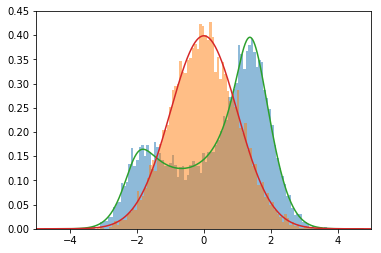

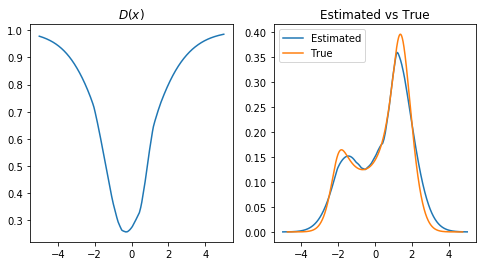

In [191]:
# The following is taken from density_estimation.py


from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
 
discriminator = train_discriminator(iter(samplers.distribution4(512)), iter(samplers.distribution3()), False)
# apply the formula f1(x) = f0(x)*D(x)/(1-D(x))
estimator = lambda x: N(x)*discriminator(torch.FloatTensor(x).reshape(len(x),1).cuda()).cpu().detach().numpy()[:,0]/(1 - discriminator(torch.FloatTensor(x).reshape(len(x),1).cuda()).cpu().detach().numpy()[:,0])

############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density



r = discriminator(torch.FloatTensor(xx).reshape(len(xx),1).cuda()).cpu().detach().numpy() # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = estimator(xx) # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')